# RDF Fitting (Optional)

This tutorial runs through some of the functionality that can be used to determine solvation radii from the RDF. It covers the default functionality and the use of custom functions to determine the radii.

It is recommended that you understand the basics of `solvation_analysis` before exploring this tutorial.

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda

from solvation_analysis.rdf_parser import plot_scipy_find_peaks_troughs, identify_cutoff_scipy
from solvation_analysis.tests import datafiles
from solvation_analysis import Solute

from scipy.signal import find_peaks

Lets make a convenience function to allow us to quickly load a precomputed RDF from a `.npz` file

In [3]:
def npz_loader(npz):
    arr = list(np.load(npz).values())[0]
    return arr

Now lets use the functionality in `solvation_analysis.rdf_parser` to quickly plot the data and determine the peaks and troughs of an the RDF.

We are going to be considering the RDF of the Butyro Nitride molecules in our test system. See the basics tutorial and the README in tests/data/ for a detailed description.

## The Default Minima Finding Method

solvation radius is 2.7


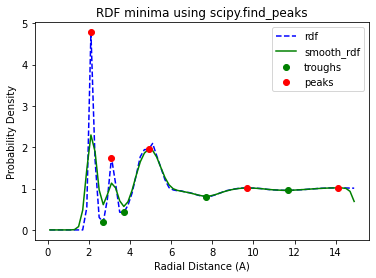

In [4]:
# example rdf plot

easy_rdf_bins = npz_loader(datafiles.easy_rdf_bins["bn_all"])
easy_rdf_data = npz_loader(datafiles.easy_rdf_data["bn_all"])

#find the cutoff point of the RDF
cutoff = identify_cutoff_scipy(easy_rdf_bins, easy_rdf_data)
print(f"solvation radius is {cutoff}")

# plot the result to check
fig, ax = plot_scipy_find_peaks_troughs(easy_rdf_bins, easy_rdf_data)
plt.show()

This approach works well for RDFs with well defined minima and is the default minima-identifying method used in `solvation_analysis`. Lets now confirm this by going though a typical calculation of solution properties.

In [5]:

# instantiate Universe
u = mda.Universe(datafiles.bn_fec_data, datafiles.bn_fec_dcd_wrap)

# define solute AtomGroup
li_atoms = u.atoms.select_atoms("type 22")

# define solvent AtomGroups
PF6 = u.atoms.select_atoms("byres type 21")
BN = u.atoms.select_atoms("byres type 5")
FEC = u.atoms.select_atoms("byres type 19")

solute = Solute.from_atoms(li_atoms, {'PF6': PF6, 'BN': BN, 'FEC': FEC}, solute_name="Li")
# run analysis
solute.run()
solute.radii

{'PF6': 2.8500000000000005, 'BN': 2.6500000000000004, 'FEC': 2.75}

Here the slight difference between the precomputed **BN** radii (2.7) and those we have generated using `Solute` (2.65) is due to the small number of frames analyzed and can be ignored.

## Using a Custom Function to Identify Minima

Due to the roughness of some RDF data, the univariate spline interpolation and critical point finding algorithms may sometimes fail to find the correct minima (if there even is one). One can either set the radii manually as is done for **PF6** in the basics tutorial, or you can supply a custom function of arbitrary complexity. 

This custom function must take the rdf bins and rdf data return a single scalar value (the minima), e.g. `foo(numpy.ndarray, numpy.ndarray) -> float`. Lets try constructing a custom cutoff finder based on Scipy's signal processing functionality. First, we'll see how the function does as a standalone operation, then, we'll integrate it into our `Solute`.

We will use `scipy.signal.find_peaks` on the **negated data** to find the minima. We will also require that the peaks have a distance of **5 samples** between them with the `distance=5` kwarg.

In [6]:
# find peaks using scipy
peaks, _  = find_peaks(-easy_rdf_data, distance=5)


solvation radius is 2.7


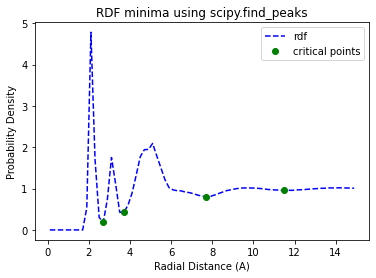

In [7]:
plt.plot(easy_rdf_bins, easy_rdf_data, "b--", label="rdf")
plt.plot(easy_rdf_bins[peaks], easy_rdf_data[peaks], "go", label="critical points")
plt.xlabel("Radial Distance (A)")
plt.ylabel("Probability Density")
plt.title("RDF minima using scipy.find_peaks")
plt.legend()

print(f"solvation radius is {easy_rdf_bins[peaks[0]]}")
plt.show()

This looks great! Our result is very close to our previous spline interpolation. Now lets try integrating it into our `Solute`.

First we need to **wrap our function** so that it's signature is `foo(bins, data) -> cutoff radii`. Remember that our function must return the radii at the **first minima** as a float and that find_peaks requires the **negated** data to find minima rather than maxima.

In [8]:
def find_peaks_wrapper(bins, data, **kwargs):
    peaks, _  = find_peaks(-data, **kwargs)
    radii = bins[peaks[0]]
    return radii

Notice we passed our `**kwargs` to the the find peaks function. This lets us use the `kernel_kwargs` argument to `Solute` to pass arbitrary kwargs to our method.

In [9]:
solute_scipy_peak = Solute.from_atoms(
    li_atoms,
    {'PF6': PF6, 'BN': BN, 'FEC': FEC},
    rdf_kernel=find_peaks_wrapper,
    kernel_kwargs={"distance": 5}
)
solute_scipy_peak.run()

{'PF6': 2.75, 'BN': 2.55, 'FEC': 2.8500000000000005}


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'solute_0 solvation distance for PF6'}, xlabel='Radial Distance (A)', ylabel='Probability Density'>)

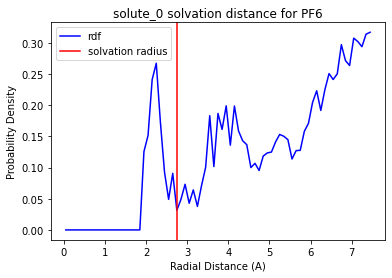

In [10]:
print(solute_scipy_peak.radii)
solute_scipy_peak.plot_solvation_radius('Li', 'PF6')

Fantastic! We have implemented our own function that can find the tricky **PF6** minima.

Now you know how to write your own custom functions and wrappers to  calculate solvation radii however you like. The possibilities are endless.